In [1]:
import sys
import matplotlib.pyplot as plt
sys.path.append('src/')
from LApprox import *

/Users/corey/anaconda3/envs/exoenv/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


Let's start with a simple example of the Laplace Approximation, that we can verify by hand. This will utilize the three main functions of our lightweight LApprox package:

1. **NDeriv_2** - numerically calculate the second derivative of a generic python function
2. **Calculate_Hessian** - Make a matrix of partial second derivatives
3. **Laplace_Approximation** - The main thing we're looking for!

We're going to start with a multivariate Guassian. This is pretty much the simplest function where it makes sense to use the Laplace Approximation. We can take its second derivatives by hand to verify that our first two functions are working, and while its integral is not doable by hand, the function has a simple enough form that we can plug it into something like Wolfram Alpha to verify that our approximation is correct.

Remember that we want to approximate the integral of a function of the form

\begin{equation}
Z = \int h(\textbf{x}) = \int exp(f(\textbf{x}))
\end{equation}

Note that we use $\textbf{x}$ to indicate that this can be a multivariable function, and, in general, those are the primary functions we are interested in approximating.

This, perhaps difficult, integral can be approximated as:

\begin{equation}
[\frac{(2\pi)^{2}}{|det(H(\textbf{x$_{0}$})|}]^{\frac{1}{2}} \times exp(f(\textbf{x$_{0}$}))
\end{equation}

Where $\textbf{x$_{0}$}$ is a local maximum, and H is the Hessian matrix of f(x). We can also think of this as the function evaluated at the local maximum multiplied by a width term, which is estimated via the Hessian matrix.

Our example function will be a simple multivariate Gaussian of the form:

\begin{equation}
h(x,y) = e^{-3x^{2} - y^{2}}
\end{equation}

In this situation, f(x,y) is simply the term in the exponent:

\begin{equation}
f(x,y) = -3x^{2} - y^{2}
\end{equation}

We define these functions below, and plot h.

In [2]:
def h(x0):
    x= x0[0]
    y = x0[1]
    return np.exp(-3*x**2 - y**2)
    
def f(x0, **kwargs):
    x = x0[0]
    y = x0[1]
    return (-3*x**2 - y**2)

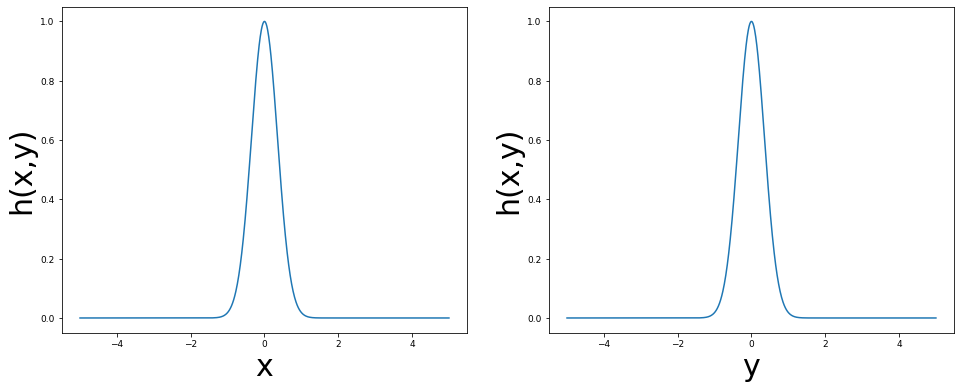

In [3]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)

plt.plot(x, h([x,y]))

plt.xlabel('x', fontsize=30)
plt.ylabel('h(x,y)', fontsize=30)

plt.subplot(1,2,2)

plt.plot(y, h([x,y]))
plt.xlabel('y', fontsize=30)
plt.ylabel('h(x,y)', fontsize=30)

plt.show()

Say we're interested in calculating the integral from -50 to 50 in each parameter set. Because most of the function is concentrated near the local maximum of (0,0), we can estimate this integral by simply taking the value and multiplying by a width term, as described above.

It is clear from inspection that the local maximum occurs at x$_{0}$ = (0,0). Thus, it is plain that exp(f(x$_{0}$)) = 1.

In [4]:
h([0,0])

1.0

Good, our function returns the same! Now to estimate the Hessian matrix. The Hessian is simply a matrix of second partial derivatives, where the ijth entry is the second partial derivative with respect to dimension i and j.

\begin{pmatrix}
\frac{\partial^{2} f}{\partial x_{0} \partial x_{0}} & ... & \frac{\partial^{2} f}{\partial x_{0} \partial x_{n}} \\
... & ... & ... \\
\frac{\partial^{2} f}{\partial x_{n} \partial x_{0}} & ... & \frac{\partial^{2} f}{\partial x_{n} \partial x_{n}} \\
\end{pmatrix}

In our simple case, the Hessian is 

\begin{pmatrix}
\frac{\partial^{2} f}{\partial x^{2}} & \frac{\partial^{2} f}{\partial x \partial y} \\
\frac{\partial^{2} f}{\partial y \partial x} & \frac{\partial^{2} f}{\partial y^{2}} \\
\end{pmatrix}


This is trivial to do by hand:

\begin{pmatrix}
-6 & 0\\
0 & -2 \\
\end{pmatrix}

Let's verify that our Hessian function can do this:

In [5]:
Calculate_Hessian(f, [0,0])

array([[-6.,  0.],
       [ 0., -2.]])

Excellent, that appears to be working! The determinant is just positive 12, so we can perform the Laplace Approximation by hand:

\begin{equation}
[\frac{(2\pi)^{2}}{|12|}]^{\frac{1}{2}} \times 1 = 1.813799364
\end{equation}

This is indeed equal to 
\begin{equation}
\int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty}e^{(-3x^{2} - y^{2})}dxdy = 1.8138
\end{equation}

According to Wolfram Alpha (This could also be done by hand, but I am being lazy).

Does our Laplace Approximation function do this successfully?

In [6]:
Laplace_Approximation(f, [0,0])

Determinant: 12.0


(0, 0.5954237415153453)

Wait, what's wrong? There's two numbers? And neither's right?

Actually, this is fine. As explained in the documentation, my Laplace Approximation function returns log(A) and log(B), where A and B are the two components of the Laplace Approximation. Adding them together, and exponentiating them, will get the correct result.

In [7]:
logA, logB = Laplace_Approximation(f, [0,0])

print(np.exp(logA + logB))

Determinant: 12.0
1.8137993642342178


And there you have it, the approximation works on a simple multi-variate Gaussian. Now, let's try using it on an actually complicated function in the next tutorial!